# Figure 3

This notebook must be run within the `benchmark_env` environment.

In [1]:
library(tidyverse)
library(ggplot2)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [5]:
lib_names <- c("KEGG_2021_Human", 
               "Reactome_2022", 
               "WikiPathway_2023_Human")
df_list <- list()
for (lib in lib_names) {
  file_path <- paste0("outputs/gsai_vs_llm2geneset_outputs_", lib, ".tsv")
  df_cur <- readr::read_tsv(file_path)
  df_cur$source <- lib
  df_list[[lib]] <- df_cur
}

df <- bind_rows(df_list)


df <- df %>%
  mutate(library = case_when(
    library == "KEGG_2021_Human" ~ "KEGG",
    library == "Reactome_2022" ~ "Reactome",
    library == "WikiPathway_2023_Human" ~ "WikiPathways",
    TRUE ~ library  # Leave other values unchanged
  ))

df <- df %>%
  mutate(model = case_when(
    model == "gpt-4o-mini-2024-07-18" ~ "GPT-4o mini",
    model == "gpt-3.5-turbo-0125" ~ "GPT-3.5",
    model == "gpt-4o-2024-08-06" ~ "GPT-4o",
    TRUE ~ model  # Leave other values unchanged
  ))

df <- df %>%
  mutate(model = factor(model, levels = c("GPT-3.5", "GPT-4o mini", "GPT-4o")))

head(df)

Rows: 1920 Columns: 11
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): model, library, gt_name, gt_name_clean, name, method
dbl (5): ROUGE1, ROUGE2, csim, in_toks, out_toks

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10908 Columns: 11
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): model, library, gt_name, gt_name_clean, name, method
dbl (5): ROUGE1, ROUGE2, csim, in_toks, out_toks

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4806 Columns: 11
── Column specification ──────────────────

model,library,gt_name,gt_name_clean,name,ROUGE1,ROUGE2,csim,method,in_toks,out_toks,source
<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
GPT-4o mini,KEGG,ABC transporters,ABC transporters,"ABC transporters in lipid metabolism, Cholesterol homeostasis, Antigen processing and presentation",1.0000000,1.0000000,0.7946675,llm2geneset,1181,1314,KEGG_2021_Human
GPT-4o mini,KEGG,AGE-RAGE signaling pathway in diabetic complications,AGE-RAGE signaling pathway in diabetic complications,"Nuclear Factor Kappa B (NF-κB) Signaling Pathway, Transforming Growth Factor Beta (TGF-β) Signaling Pathway, Angiotensin II Signaling Pathway, Extracellular Matrix (ECM) Organization, MAPK (Mitogen-Activated Protein Kinase) Signaling Pathway",0.2857143,0.1666667,0.5126740,llm2geneset,1463,1783,KEGG_2021_Human
GPT-4o mini,KEGG,AMPK signaling pathway,AMPK signaling pathway,"Insulin signaling pathway, AMP-activated protein kinase (AMPK) signaling pathway, Mammalian target of rapamycin (mTOR) signaling pathway, Fatty acid metabolism, Glycolysis and gluconeogenesis",1.0000000,1.0000000,0.8751987,llm2geneset,1544,1363,KEGG_2021_Human
GPT-4o mini,KEGG,Acute myeloid leukemia,Acute myeloid leukemia,"PI3K/Akt signaling pathway, NF-kB signaling pathway, Regulation of cytokine production, Apoptosis signaling pathway",0.0000000,0.0000000,0.2664708,llm2geneset,1258,1927,KEGG_2021_Human
GPT-4o mini,KEGG,Adherens junction,Adherens junction,"Adherens junctions, Actin cytoskeleton organization, TGF-beta signaling pathway, Wnt signaling pathway, EGFR signaling pathway",1.0000000,1.0000000,0.9302434,llm2geneset,1269,1697,KEGG_2021_Human
GPT-4o mini,KEGG,Adipocytokine signaling pathway,Adipocytokine signaling pathway,"Adipocytokine Signaling Pathway, TNF Signaling Pathway, Fatty Acid Metabolism, Insulin Signaling Pathway, AMPK Signaling Pathway",1.0000000,1.0000000,0.9999989,llm2geneset,1284,1688,KEGG_2021_Human


In [3]:
colnames(df)

[1] "model"         "library"       "gt_name"       "gt_name_clean"
 [5] "name"          "ROUGE1"        "ROUGE2"        "csim"         
 [9] "method"        "in_toks"       "out_toks"      "source"

In [4]:
# Group by 'model' and 'method', and calculate the mean of 'ROUGE1', 'ROUGE2', and 'csim'
df_summary <- df %>%
  group_by(model, method, library) %>%
  summarize(
    mean_ROUGE1 = mean(ROUGE1, na.rm = TRUE),  # Compute mean of ROUGE1
    mean_ROUGE2 = mean(ROUGE2, na.rm = TRUE),  # Compute mean of ROUGE2
    mean_csim = mean(csim, na.rm = TRUE),       # Compute mean of csim
    in_toks = sum(in_toks),
    out_toks = sum(out_toks)
  ) %>%
  ungroup()  # Ungroup the data

# View the summarized data frame
head(df_summary)

`summarise()` has grouped output by 'model', 'method'. You can override using the `.groups` argument.


model,method,library,mean_ROUGE1,mean_ROUGE2,mean_csim,in_toks,out_toks
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GPT-3.5,GSAI,KEGG,0.3065365,0.13786458,0.4873091,454514,72062
GPT-3.5,GSAI,Reactome,0.2039449,0.04947202,0.4993828,2260439,442550
GPT-3.5,GSAI,WikiPathways,0.2398407,0.09114756,0.4914126,923864,194961
GPT-3.5,llm2geneset,KEGG,0.4543006,0.33247768,0.6233366,459593,385875
GPT-3.5,llm2geneset,Reactome,0.2342751,0.09140654,0.5304419,2284765,2238745
GPT-3.5,llm2geneset,WikiPathways,0.2715906,0.13350146,0.5327091,937731,908727


In [30]:
df_long <- df_summary %>%
  pivot_longer(cols = c(mean_ROUGE1, mean_ROUGE2, mean_csim),  # Columns to pivot
               names_to = "metric",  # New column for the metric names (ROUGE1, ROUGE2, csim)
               values_to = "mean_value")  # New column for the mean values

# View the transformed data frame
head(df_long)

model,method,library,in_toks,out_toks,metric,mean_value
<fct>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
GPT-3.5,GSAI,KEGG,454514,72062,mean_ROUGE1,0.30653646
GPT-3.5,GSAI,KEGG,454514,72062,mean_ROUGE2,0.13786458
GPT-3.5,GSAI,KEGG,454514,72062,mean_csim,0.48730912
GPT-3.5,GSAI,Reactome,2260439,442550,mean_ROUGE1,0.20394485
GPT-3.5,GSAI,Reactome,2260439,442550,mean_ROUGE2,0.04947202
GPT-3.5,GSAI,Reactome,2260439,442550,mean_csim,0.49938285


In [31]:

df_long <- df_long %>%
  mutate(metric = case_when(
    metric == "mean_csim" ~ "Cosine Similarity",
    metric == "mean_ROUGE1" ~ "Shared Unigrams",
    metric == "mean_ROUGE2" ~ "Shared Bigrams",
    TRUE ~ metric  # Leave other values unchanged
  ))

df_long <- df_long %>%
  mutate(metric = factor(metric, levels = c("Shared Unigrams", "Shared Bigrams", 
                                            "Cosine Similarity")))



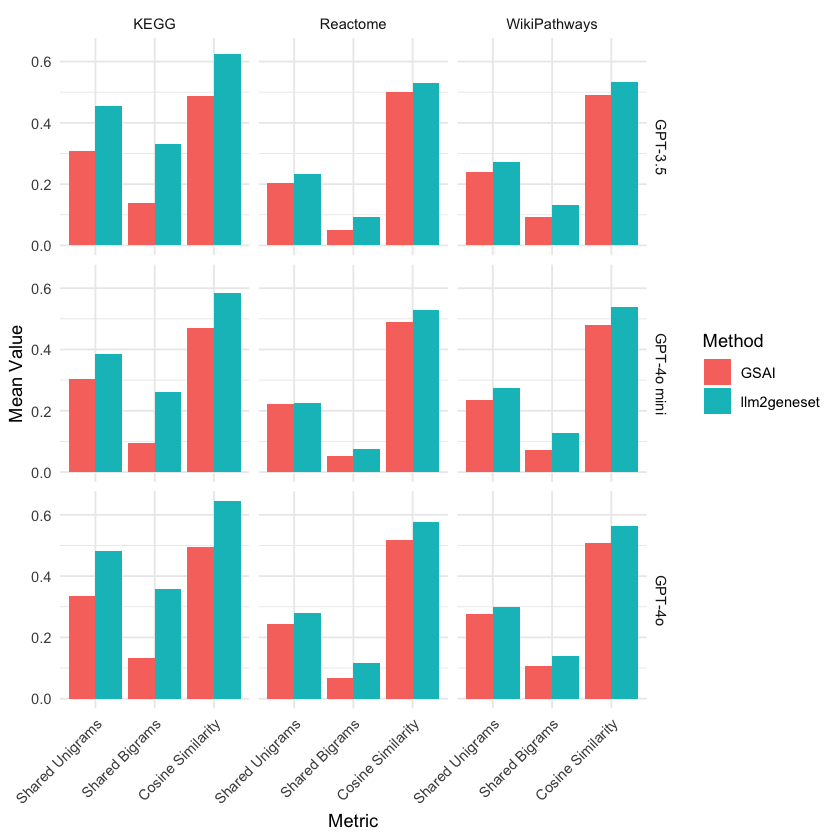

In [32]:

# Create a bar plot of 'mean_value', grouped by 'metric' and filled by 'method', faceted by 'model' and 'library'
p <- ggplot(df_long, aes(x = metric, y = mean_value, fill = method)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create a grouped bar plot with side-by-side bars
  facet_grid(model ~ library) +  # Facet by 'model' across rows and 'library' across columns
  labs(x = "Metric", y = "Mean Value", fill = "Method") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
p

In [15]:
ggsave(p, file="figures/figS3A.pdf")

Saving 7 x 7 in image


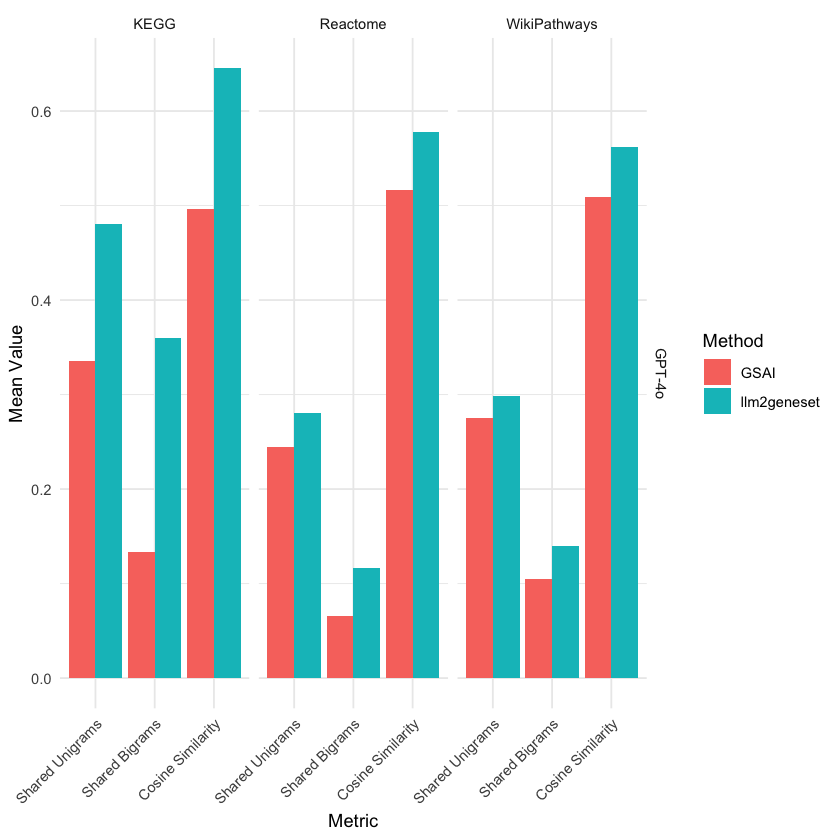

In [33]:

# Create a bar plot of 'mean_value', grouped by 'metric' and filled by 'method', faceted by 'model' and 'library'
p <- ggplot(df_long %>% filter(model == "GPT-4o"), aes(x = metric, y = mean_value, fill = method)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create a grouped bar plot with side-by-side bars
 facet_grid(model ~ library) +  # Facet by 'model' across rows and 'library' across columns
  labs(x = "Metric", y = "Mean Value", fill = "Method") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
p

In [17]:
ggsave(p, file="figures/fig3b.pdf", height=4)

Saving 7 x 4 in image


Saving 7 x 7 in image


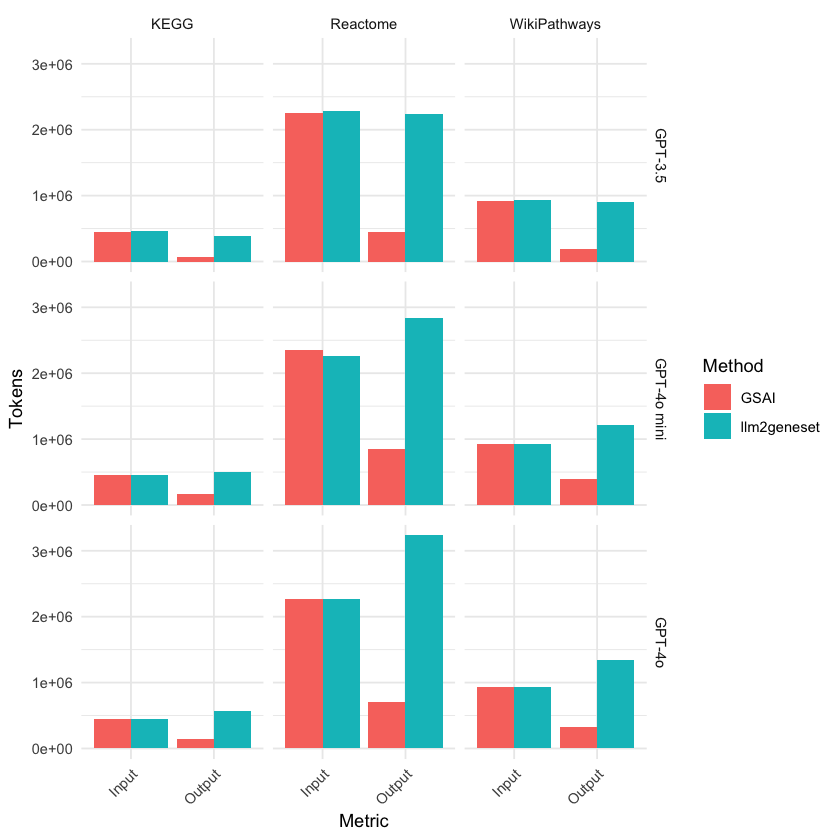

In [34]:
df_long <- df_summary %>%
  pivot_longer(cols = c(in_toks, out_toks),  # Columns to pivot
               names_to = "metric",  # New column for the metric names (ROUGE1, ROUGE2, csim)
               values_to = "mean_value")  # New column for the mean values

df_long <- df_long %>%
  mutate(metric = case_when(
    metric == "in_toks" ~ "Input",
    metric == "out_toks" ~ "Output",
    TRUE ~ metric  # Leave other values unchanged
  ))

# Create a bar plot of 'mean_value', grouped by 'metric' and filled by 'method', faceted by 'model' and 'library'
p <- ggplot(df_long, aes(x = metric, y = mean_value, fill = method)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create a grouped bar plot with side-by-side bars
  facet_grid(model ~ library) +  # Facet by 'model' across rows and 'library' across columns
  labs(x = "Metric", y = "Tokens", fill = "Method") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
p
ggsave(p, file="figures/figS3b.pdf")

# Figure 3D

In [29]:
df <- readr::read_tsv("outputs/mix_genesets_outputs.tsv")

df <- df %>%
  mutate(library = case_when(
    library == "KEGG_2021_Human" ~ "KEGG",
    library == "Reactome_2022" ~ "Reactome",
    library == "WikiPathway_2023_Human" ~ "WikiPathways",
    TRUE ~ library  # Leave other values unchanged
  ))

df <- df %>%
  mutate(model = case_when(
    model == "gpt-4o-mini-2024-07-18" ~ "GPT-4o mini",
    model == "gpt-3.5-turbo-0125" ~ "GPT-3.5",
    model == "gpt-4o-2024-08-06" ~ "GPT-4o",
    TRUE ~ model  # Leave other values unchanged
  ))

df <- df %>%
  mutate(model = factor(model, levels = c("GPT-3.5", "GPT-4o mini", "GPT-4o")))

head(df)


Rows: 900 Columns: 9
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): model, library, gt_name, gt_name_clean, name, method
dbl (3): ROUGE1, ROUGE2, csim

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


model,library,gt_name,gt_name_clean,name,ROUGE1,ROUGE2,csim,method
<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
GPT-4o mini,KEGG,"Glycolysis / Gluconeogenesis, Wnt signaling pathway","Glycolysis / Gluconeogenesis, Wnt signaling pathway",Wnt signaling pathway regulation and development,0.6000000,0.50,0.5599836,GSAI
GPT-4o mini,KEGG,"Amino sugar and nucleotide sugar metabolism, Ubiquitin mediated proteolysis","Amino sugar and nucleotide sugar metabolism, Ubiquitin mediated proteolysis",Ubiquitin-mediated proteolysis and protein modification,0.4444444,0.25,0.6242138,GSAI
GPT-4o mini,KEGG,"Fatty acid elongation, Pentose phosphate pathway","Fatty acid elongation, Pentose phosphate pathway",Lipid and carbohydrate metabolism integration,0.0000000,0.00,0.4762700,GSAI
GPT-4o mini,KEGG,"Glycerophospholipid metabolism, Phosphatidylinositol signaling system","Glycerophospholipid metabolism, Phosphatidylinositol signaling system",Phosphoinositide metabolism and signaling,0.4000000,0.00,0.7901952,GSAI
GPT-4o mini,KEGG,"B cell receptor signaling pathway, Oxidative phosphorylation","B cell receptor signaling pathway, Oxidative phosphorylation",Mitochondrial Bioenergetics and Immune Signaling,0.1428571,0.00,0.5641305,GSAI
GPT-4o mini,KEGG,"Non-homologous end-joining, Ubiquitin mediated proteolysis","Non-homologous end-joining, Ubiquitin mediated proteolysis",Protein Ubiquitination and Degradation Pathway,0.1428571,0.00,0.5091289,GSAI


In [30]:
# Group by 'model' and 'method', and calculate the mean of 'ROUGE1', 'ROUGE2', and 'csim'
df_summary <- df %>%
  group_by(model, method, library) %>%
  summarize(
    mean_ROUGE1 = mean(ROUGE1, na.rm = TRUE),  # Compute mean of ROUGE1
    mean_ROUGE2 = mean(ROUGE2, na.rm = TRUE),  # Compute mean of ROUGE2
    mean_csim = mean(csim, na.rm = TRUE),       # Compute mean of csim
  ) %>%
  ungroup()  # Ungroup the data

# View the summarized data frame
head(df_summary)

`summarise()` has grouped output by 'model', 'method'. You can override using the `.groups` argument.


model,method,library,mean_ROUGE1,mean_ROUGE2,mean_csim
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
GPT-3.5,GSAI,KEGG,0.3236746,0.14250000,0.5687956
GPT-3.5,GSAI,Reactome,0.2880574,0.09745405,0.5834309
GPT-3.5,GSAI,WikiPathways,0.3367198,0.15466667,0.6121961
GPT-3.5,llm2geneset,KEGG,0.6859841,0.46738095,0.7284601
GPT-3.5,llm2geneset,Reactome,0.4269931,0.23641814,0.6505657
GPT-3.5,llm2geneset,WikiPathways,0.5367503,0.27926263,0.6854255


model,method,library,metric,mean_value
<fct>,<chr>,<chr>,<chr>,<dbl>
GPT-3.5,GSAI,KEGG,mean_ROUGE1,0.32367460
GPT-3.5,GSAI,KEGG,mean_ROUGE2,0.14250000
GPT-3.5,GSAI,KEGG,mean_csim,0.56879560
GPT-3.5,GSAI,Reactome,mean_ROUGE1,0.28805736
GPT-3.5,GSAI,Reactome,mean_ROUGE2,0.09745405
GPT-3.5,GSAI,Reactome,mean_csim,0.58343085


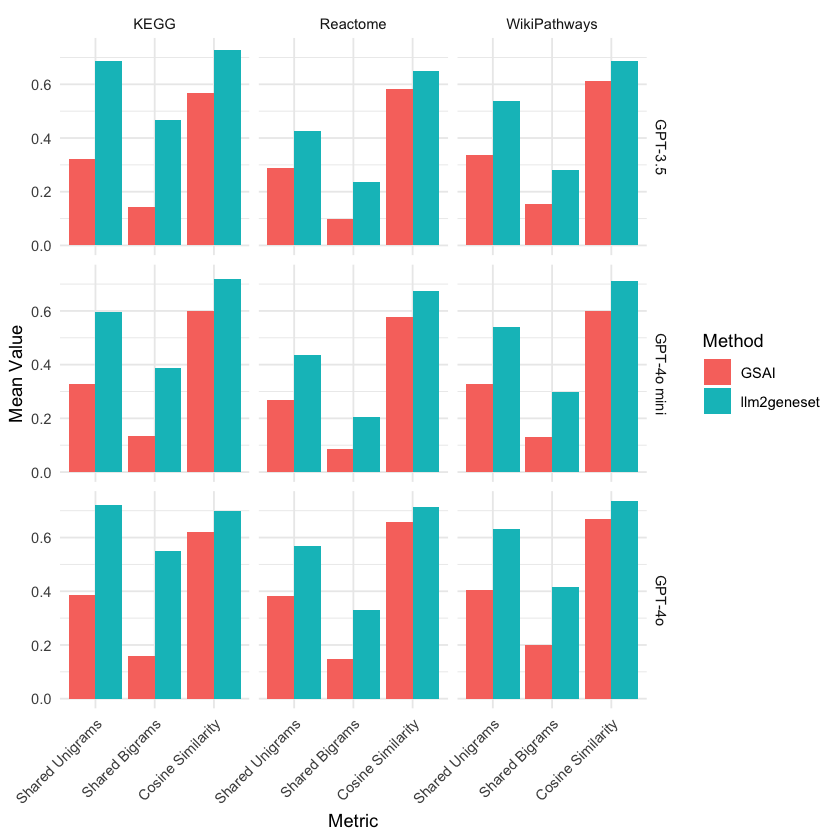

In [31]:
df_long <- df_summary %>%
  pivot_longer(cols = c(mean_ROUGE1, mean_ROUGE2, mean_csim),  # Columns to pivot
               names_to = "metric",  # New column for the metric names (ROUGE1, ROUGE2, csim)
               values_to = "mean_value")  # New column for the mean values

# View the transformed data frame
head(df_long)

df_long <- df_long %>%
  mutate(metric = case_when(
    metric == "mean_csim" ~ "Cosine Similarity",
    metric == "mean_ROUGE1" ~ "Shared Unigrams",
    metric == "mean_ROUGE2" ~ "Shared Bigrams",
    TRUE ~ metric  # Leave other values unchanged
  ))

df_long <- df_long %>%
  mutate(metric = factor(metric, levels = c("Shared Unigrams", "Shared Bigrams", 
                                            "Cosine Similarity")))


# Create a bar plot of 'mean_value', grouped by 'metric' and filled by 'method', faceted by 'model' and 'library'
p <- ggplot(df_long, aes(x = metric, y = mean_value, fill = method)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create a grouped bar plot with side-by-side bars
  facet_grid(model ~ library) +  # Facet by 'model' across rows and 'library' across columns
  labs(x = "Metric", y = "Mean Value", fill = "Method") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
p

In [32]:
ggsave(p, file='figures/figS3C.pdf')

Saving 7 x 7 in image


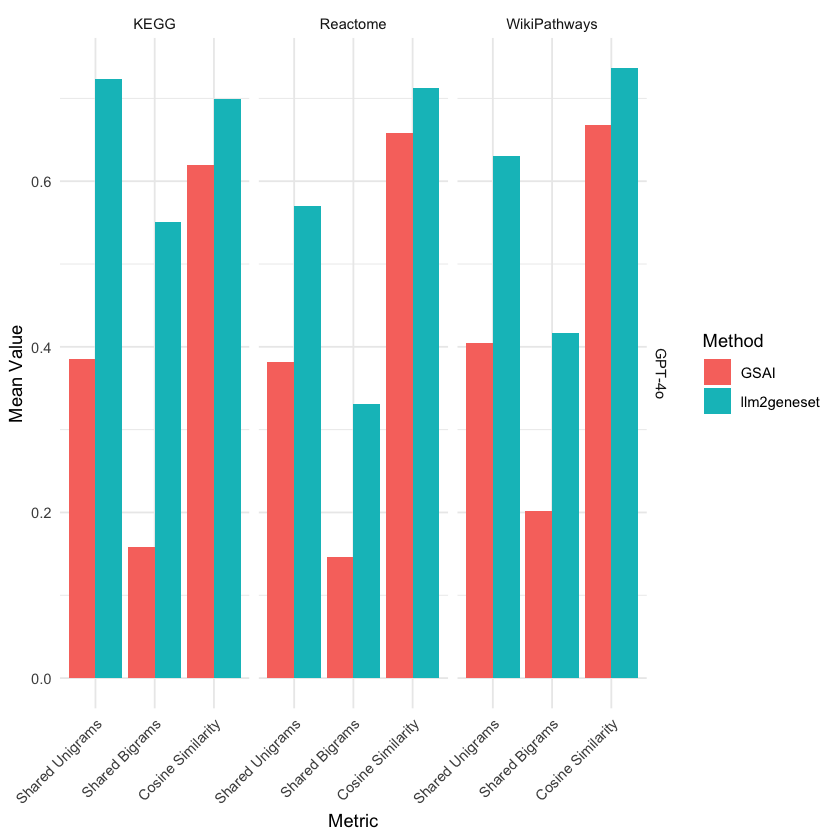

In [33]:
# Create a bar plot of 'mean_value', grouped by 'metric' and filled by 'method', faceted by 'model' and 'library'
p <- ggplot(df_long %>% filter(model == "GPT-4o"), aes(x = metric, y = mean_value, fill = method)) +
  geom_bar(stat = "identity", position = "dodge") +  # Create a grouped bar plot with side-by-side bars
  facet_grid(model ~ library) +  # Facet by 'model' across rows and 'library' across columns
  labs(x = "Metric", y = "Mean Value", fill = "Method") +  # Set axis and legend labels
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Rotate x-axis labels for readability
p

In [34]:
ggsave(p, file="figures/fig3d.pdf", height=4)

Saving 7 x 4 in image
